# Road Object Detection using Fine-Tuned Pre-Trained Neural Networks 
**Advanced Intelligent Systems - Final Project**

*Group Members*
- Advincula, Andre Frederick
- Alvarez, Aaron Jetro
- Dee, Giann Wayne
- Gulinao, Lance Owen
- Laguna, Ivan Matthew
- Uy, Alec Matthew
- Verceles, Miguel Angelo




## Objectives

1. **Dataset Exploration and Understanding**  
   - Analyze the BDD100K dataset, focusing on object classes, distributions, and label properties, to assess its suitability for object detection tasks.

2. **Data Preprocessing and Preparation**  
   - Prepare images and annotations for YOLO by resizing, normalizing, and converting labels into YOLO-compatible formats to maximize model efficiency.

3. **Model Selection and Training**  
   - Fine-tune a YOLOv8 model (initially pre-trained on a generic dataset) for specific road object detection tasks, adjusting parameters like batch size, image size, and number of epochs to optimize performance on the BDD100K dataset.

4. **Evaluation and Analysis of Detection Performance**  
   - Evaluate the YOLO model’s object detection accuracy using metrics like mAP (mean Average Precision), precision, and recall, comparing pre- and post-fine-tuning results.

5. **Insights on YOLOv8 Fine-Tuning**  
   - Document findings on how fine-tuning parameters influence YOLO's ability to detect road objects, identifying challenges and potential improvements for future work.

6. **Comparison with Benchmark Models (if applicable)**  
   - Optionally, compare YOLO’s detection performance with other state-of-the-art models to contextualize results and highlight YOLO’s strengths and limitations.


# 1) Importing Libraries and data set

### Installing and Importing libraries for the modelling process

In [99]:
!pip install -q tensorflow --disable-pip-version-check
!pip install -q numpy --disable-pip-version-check
!pip install -q pandas --disable-pip-version-check
!pip install -q matplotlib --disable-pip-version-check
!pip install -q pydot --disable-pip-version-check
!pip install -q opencv-python --disable-pip-version-check
!pip install -q tqdm --disable-pip-version-check
!pip install -q pytorch
!pip install -q kagglehub
!pip install -q ultralytics opencv-python-headless matplotlib bdd100k

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Aaron\AppData\Local\Temp\pip-install-vhaie9ez\pytorch_285f0b21d92246909020ff42e189978f\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notic

In [109]:
# Add the directory to the Python path
import sys
sys.path.append('/content/')

# Import the modules
import metrictools as mt
import exploratorymethods as em
import bddtools as bt

# Reload the modules if needed
import importlib
importlib.reload(mt)
importlib.reload(em)
importlib.reload(bt)

from ultralytics import YOLO
import matplotlib.pyplot as plt
import kagglehub
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
%matplotlib inline

### Downloading the dataset

In [5]:

# Download latest version of the dataset, if the download stops/faces an error, you can rerun and it will continue to download.
path = kagglehub.dataset_download("solesensei/solesensei_bdd100k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Aaron\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2


### Specifying paths for easier access in the notebook

Before proceeding, make sure that you have a folder named "dataset". For easier access I recommmend that you put it in the same directory as where your notebook is located. 

**Some notes**
 - For now, your labels will only have the .json files as it will be converted automatically using this notebook.
 - dataset.yaml must be created manually in the same folder where your notebook is located. A copy is provided in the repository as well

![File Structure](file%20structure.png)



In [7]:
# Paths to JSON annotation files and output label directories. Specify the path of the labels.json here
annotations_train_path = os.path.join(path,"bdd100k_labels_release","bdd100k","labels", "bdd100k_labels_images_train.json")
annotations_val_path = os.path.join(path, "bdd100k_labels_release","bdd100k","labels", "bdd100k_labels_images_val.json")
images_train_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","train")
images_val_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","val")
images_test_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","test")
images_train_path10k = os.path.join(path, "bdd100k","bdd100k","images", "10k","train")
images_val_path10k = os.path.join(path, "bdd100k","bdd100k","images", "10k","val")
images_test_path10k = os.path.join(path, "bdd100k","bdd100k","images", "10k","test")

# Updated output directories for converted YOLO labels. this must point to the labels folder specified in the previous cell block.
output_labels_train_path = "dataset1/labels/train"
output_labels_val_path = "dataset1/labels/val"
image_width, image_height = 1280, 720

class_mapping = {
    "car": 0,
    "truck": 1,
    "bus": 2,
    "motorcycle": 3,
    "bicycle": 4,
    "pedestrian": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "train": 8,
    "rider": 9
}

In [ ]:
# moving folders from the download folder to the notebook folder
bt.move_files(source_dir=images_train_path, destination_dir="dataset1/images/train")
bt.move_files(source_dir=images_val_path, destination_dir="dataset1/images/val")
bt.move_files(source_dir=images_test_path, destination_dir="dataset1/images/test")

Moving items: 100%|██████████| 1160/1160 [00:00<00:00, 1986.42it/s]


Moved 1160 item(s) from C:\Users\Aaron\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2\bdd100k\bdd100k\images\100k\train to dataset/images/train.


Moving items: 100%|██████████| 10000/10000 [00:05<00:00, 1989.12it/s]


Moved 10000 item(s) from C:\Users\Aaron\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2\bdd100k\bdd100k\images\100k\val to dataset/images/val.


Moving items: 100%|██████████| 293/293 [00:00<00:00, 1645.60it/s]

Moved 293 item(s) from C:\Users\Aaron\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2\bdd100k\bdd100k\images\100k\test to dataset/images/test.


# 2) Exploratory Data Analysis

### Preprocessing Data For EDA

In [25]:
# Converting BDD100k data labels to YOLO Format

bt.convert_annotations_to_yolo(
    annotations_train_path, 
    annotations_val_path, 
    output_labels_train_path, 
    output_labels_val_path, 
    image_width, 
    image_height, 
    class_mapping
)

Processing training annotations...
Processing validation annotations...
Conversion complete! YOLO labels are saved in the specified output directories.


In [75]:
# Making a dataframe copy of YOLO labels for EDA

train_labels_df = bt.yolo_labels_to_dataframe(output_labels_train_path, image_width, image_height)
val_labels_df = bt.yolo_labels_to_dataframe(output_labels_val_path, image_width, image_height)

# Display the first few rows of the DataFrames
print("Train Labels:")
print(train_labels_df.head())
print("\nValidation Labels:")
print(val_labels_df.head())

Processing YOLO labels: 100%|██████████| 10000/10000 [00:42<00:00, 237.56it/s]


Train Labels:
                filename  class_id     x_center    y_center  bbox_width  \
0  0000f77c-6257be58.jpg         6  1141.440454  172.029967   31.076381   
1  0000f77c-6257be58.jpg         6  1174.243303  173.756430   34.529315   
2  0000f77c-6257be58.jpg         7  1136.261056  222.344114   69.058627   
3  0000f77c-6257be58.jpg         7    50.190823   61.536163  100.381647   
4  0000f77c-6257be58.jpg         0   201.523379  371.218291  312.564919   

   bbox_height          area  aspect_ratio  
0    77.690957   2414.353780      0.400000  
1    74.238026   2563.388185      0.465116  
2    22.444054   1549.955554      3.076923  
3   122.579065  12304.688432      0.818913  
4   233.375848  72945.103027      1.339320  

Validation Labels:
                filename  class_id     x_center    y_center  bbox_width  \
0  b1c66a42-6f7d68ca.jpg         7  1020.662807  304.451987   39.928130   
1  b1c66a42-6f7d68ca.jpg         7   244.559792  200.888400   59.892194   
2  b1c66a42-6f7d68ca

### Data Metrics

In [60]:
em.plot_class_distribution(train_labels_df, val_labels_df, class_mapping)

NameError: name 'train_labels_df' is not defined

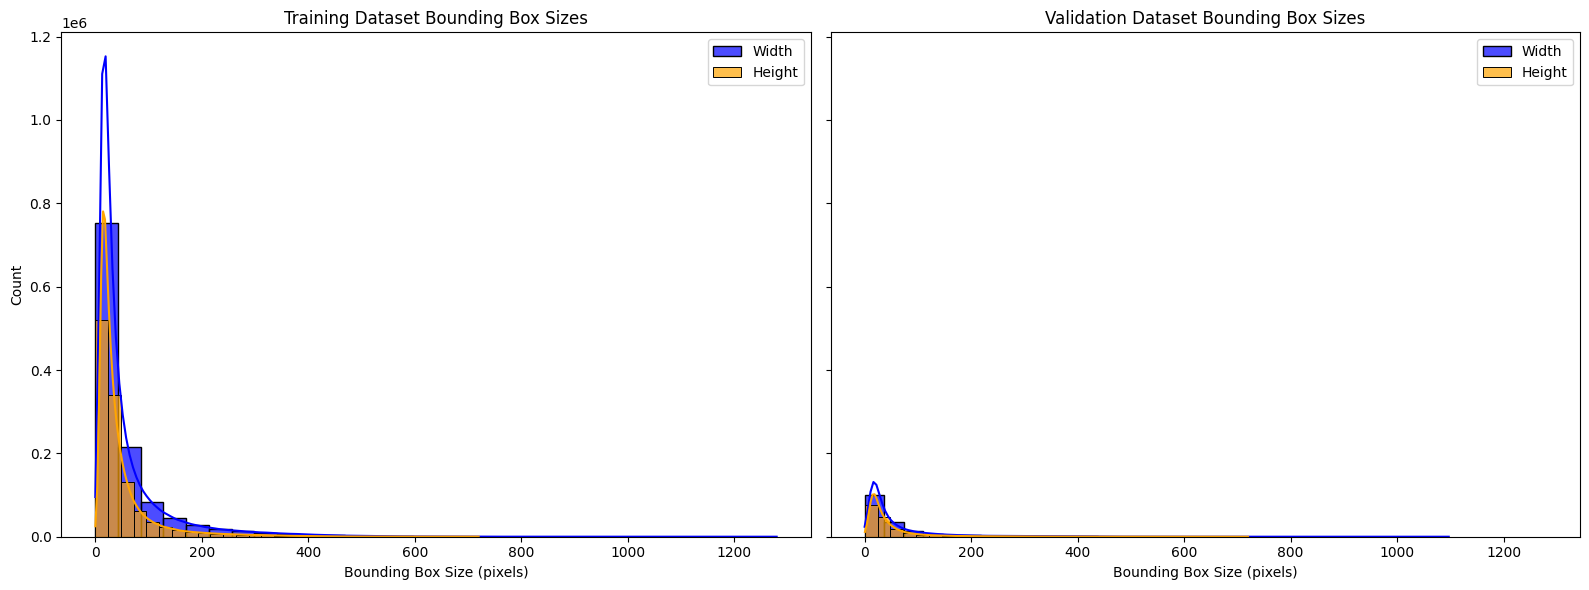

In [77]:
em.plot_bbox_size_distribution(train_labels_df, val_labels_df)

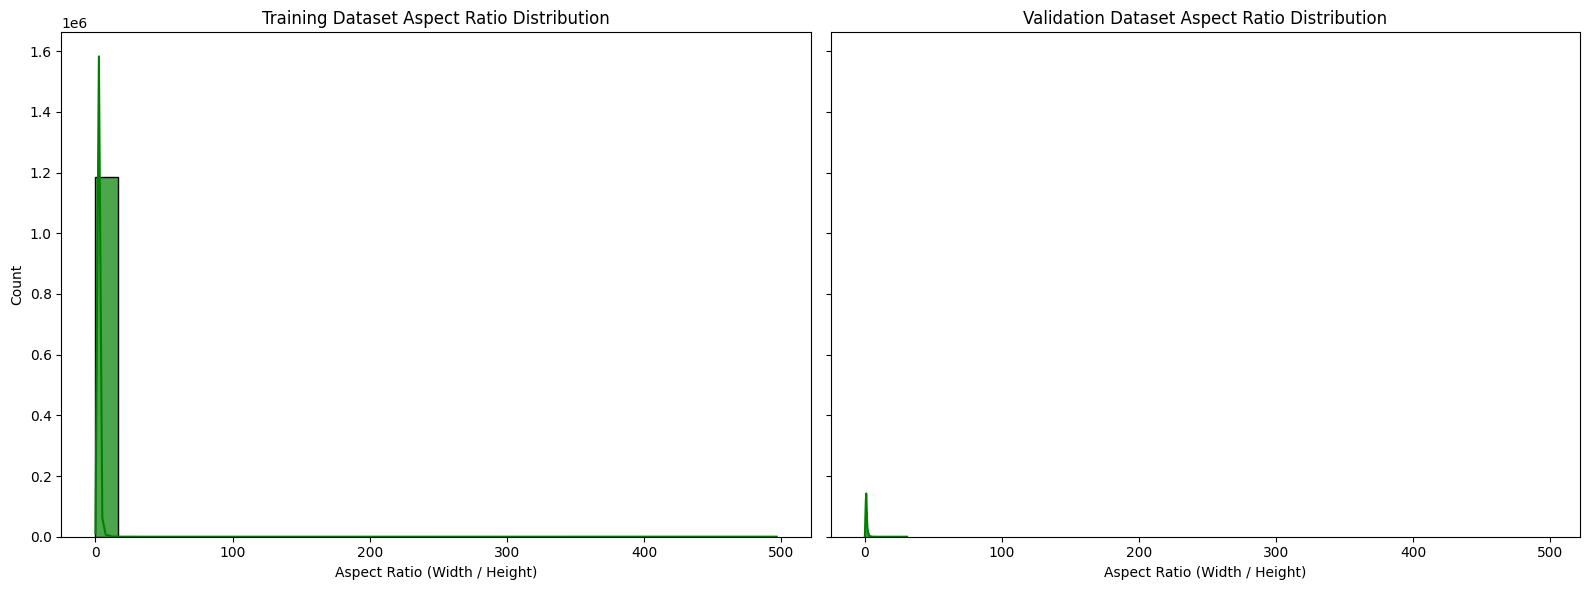

In [78]:
em.plot_aspect_ratio_distribution(train_labels_df, val_labels_df)

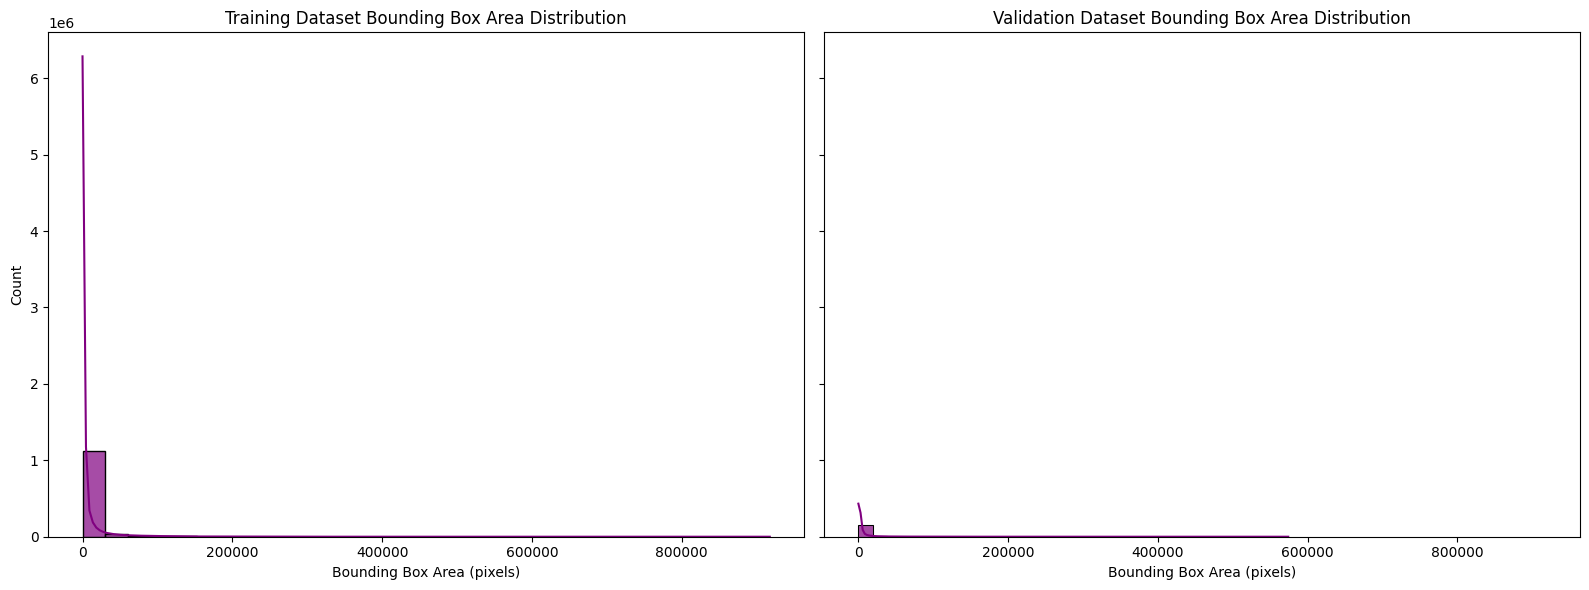

In [79]:
em.plot_bbox_area_distribution(train_labels_df, val_labels_df)

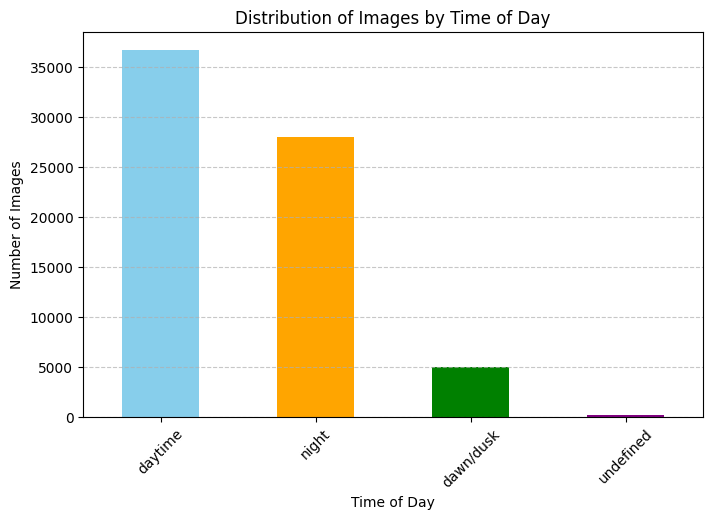

In [80]:
em.analyze_time_of_day(annotations_train_path)

### Checking If data has been properly imported and processed by making an inference using Yolo Models

#### YOLO V8

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]



image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 12 cars, 1 truck, 127.0ms
Speed: 11.0ms preprocess, 127.0ms inference, 18.8ms postprocess per image at shape (1, 3, 384, 640)


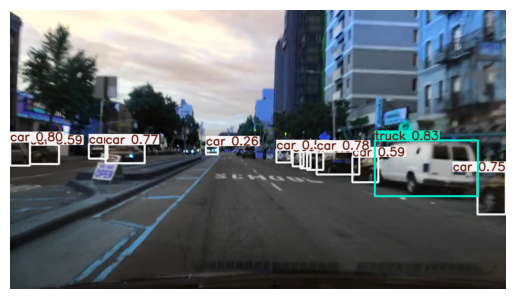

In [ ]:

# Load a pre-trained YOLOv8 model (choose from "yolov8n.pt", "yolov8s.pt", "yolov8m.pt", "yolov8l.pt", "yolov8x.pt" based on your requirements)
model = YOLO("yolov8n.pt")  # "yolov8n.pt" is the nano model, which is fastest but least accurate

# Run inference on an image (replace with your image path)
results = model("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()


#### YOLO V5

100%|██████████████████████████████████████████████████████████████████████████████| 17.7M/17.7M [00:00<00:00, 101MB/s]



image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 13 cars, 1 truck, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


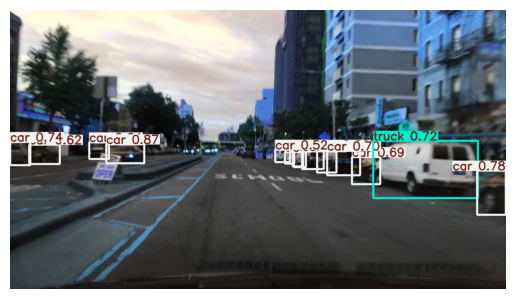

In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLOv5 model
model = YOLO("yolov5su.pt")  # replace with your desired model size

# Perform inference on a single image
results = model("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



# 3) Model Implementation and Fine-tuning

## Dataset Preparation

This part will automate the creation of the .yaml files and the creation of the needed folders along with the proper structure. Our experiments will involve using 4 variations of the data set.

1) <b>Dataset 1</b>: Original dataset with 100k images. 70k for training, 10k for validation, and 20k for testing. 
2) <b>Dataset 2</b>: Mid sized dataset with 10k images, 7k for training, 2k for validation, and 1k for testing.
3) <b>Dataset 3</b>: Small sized dataset with 1.5k images (random sampling), 1k for training, 500 for validation. (testing is taken from the larger datasets)
4) <b>Dataset 4</b>: Small sized dataset with 1.5k images (stratified sampling). Same structure as dataset 3.
5) <b>Dataset 5</b>: Original dataset with Oversampling to handle class imbalance

In [ ]:
# FOR DATASET1

#moving images from subfolders to the main folders to follow YOLO's folder structure
bt.flatten_folders(source_dir="dataset1/images/train", destination_dir="dataset1/images/train")
bt.flatten_folders(source_dir="dataset1/images/val", destination_dir="dataset1/images/val")
bt.flatten_folders(source_dir="dataset1/images/test", destination_dir="dataset1/images/test")

Flattening folders: 100%|██████████| 70000/70000 [00:59<00:00, 1175.48it/s]


Moved 70000 files from 'dataset/images/train' to 'dataset/images/train'.


Flattening folders: 100%|██████████| 10000/10000 [00:03<00:00, 2658.84it/s]


Moved 10000 files from 'dataset/images/val' to 'dataset/images/val'.


Flattening folders: 100%|██████████| 20000/20000 [00:11<00:00, 1752.10it/s]

Moved 20000 files from 'dataset/images/test' to 'dataset/images/test'.


In [28]:
# FOR DATASET2
# moving folders from the download folder to the notebook folder
bt.copy_files(source_dir="dataset1/images/train", items = 7000,destination_dir="dataset2/images/train")
bt.copy_files(source_dir="dataset1/images/val", items = 2000,destination_dir="dataset2/images/val")
bt.copy_files(source_dir="dataset1/images/test", items = 1000, destination_dir="dataset2/images/test")
bt.convert_annotations_to_yolo(annotations_train_path, annotations_val_path, "dataset2/labels/train", 
                               "dataset2/labels/val", image_width, image_height, class_mapping)

Copying files: 100%|██████████| 2000/2000 [00:00<00:00, 50948.74it/s]


Copying complete. Skipped 2000 files due to existing duplicates.
Copied 0 new files to 'dataset2/images/train'.


Copying files: 100%|██████████| 500/500 [00:00<00:00, 53690.53it/s]


Copying complete. Skipped 500 files due to existing duplicates.
Copied 0 new files to 'dataset2/images/val'.


Copying files: 100%|██████████| 289/289 [00:00<00:00, 48914.65it/s]


Copying complete. Skipped 289 files due to existing duplicates.
Copied 0 new files to 'dataset2/images/test'.
Processing training annotations...
Processing validation annotations...
Conversion complete! YOLO labels are saved in the specified output directories.


In [ ]:
# For Dataset 3
bt.copy_files(source_dir="dataset1/images/train",items=1000,destination_dir="dataset3/images/train")
bt.copy_files(source_dir="dataset1/images/val",items=500,destination_dir="dataset3/images/val")
bt.convert_annotations_to_yolo(annotations_train_path, annotations_val_path, "dataset3/labels/train", 
                               "dataset3/labels/val", image_width, image_height, class_mapping)

Copying files: 100%|██████████| 1000/1000 [00:05<00:00, 181.64it/s]


Copying complete. Skipped 0 files due to existing duplicates.
Copied 1000 new files to 'dataset3/images/train'.


Copying files: 100%|██████████| 500/500 [00:01<00:00, 329.47it/s]


Copying complete. Skipped 0 files due to existing duplicates.
Copied 500 new files to 'dataset3/images/val'.
Processing training annotations...
Processing validation annotations...
Conversion complete! YOLO labels are saved in the specified output directories.


In [ ]:
#For Dataset 4

bt.convert_annotations_to_yolo(annotations_train_path, annotations_val_path, "dataset4/labels/train", 
                               "dataset4/labels/val", image_width, image_height, class_mapping)
bt.copy_files(source_dir="dataset1/images/train",pick = "picked_train.json",destination_dir="dataset4/images/train")
bt.copy_files(source_dir="dataset1/images/val",pick = "picked_val.json",destination_dir="dataset4/images/val")

Processing training annotations...
Processing validation annotations...
Conversion complete! YOLO labels are saved in the specified output directories.


Copying files: 100%|██████████| 1000/1000 [00:07<00:00, 135.07it/s]


Copying complete. Skipped 0 files due to existing duplicates.
Copied 1000 new files to 'dataset4/images/train'.


Copying files: 100%|██████████| 500/500 [00:01<00:00, 302.63it/s]

Copying complete. Skipped 0 files due to existing duplicates.
Copied 500 new files to 'dataset4/images/val'.


In [117]:
# Creating the .YAML FILES
# Base path where datasets are located
base_path = os.path.abspath(".")
# Output directory for YAML files
output_yaml_dir = "yaml_files"
# Create YAML files for all datasets
for dataset in ["dataset1", "dataset2", "dataset3", "dataset4","dataset5"]:
    bt.create_dataset_yaml(dataset, base_path, output_yaml_dir, class_mapping)


YAML file created at: yaml_files\dataset1.yaml
YAML file created at: yaml_files\dataset2.yaml
YAML file created at: yaml_files\dataset3.yaml
YAML file created at: yaml_files\dataset4.yaml
YAML file created at: yaml_files\dataset5.yaml


## Data Preprocessing

Applying additional preprocessing to handle class imbalance

In [ ]:

import os
import random
import shutil
import math
from PIL import Image
import torchvision.transforms as transforms

# Paths
dataset4_path = "dataset4"
dataset5_path = "dataset5"

# Helper functions
def parse_yolo_label(label_path):
    labels = []
    with open(label_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels.append([class_id, *bbox])
    return labels

def save_yolo_label(label_path, labels):
    with open(label_path, "w") as file:
        for label in labels:
            class_id, x, y, w, h = label
            file.write(f"{class_id} {x} {y} {w} {h}\n")

# Adjust bounding boxes for rotation
def adjust_labels_for_rotation(labels, angle, image_width, image_height):
    angle_rad = math.radians(angle)
    center_x = 0.5  # Image center in normalized coordinates
    center_y = 0.5

    adjusted_labels = []
    for label in labels:
        class_id, x, y, w, h = label
        x -= 0.5  # Shift to origin
        y -= 0.5

        # Apply rotation transformation
        new_x = x * math.cos(angle_rad) - y * math.sin(angle_rad)
        new_y = x * math.sin(angle_rad) + y * math.cos(angle_rad)

        new_x += 0.5  # Shift back to image space
        new_y += 0.5

        # Ensure bounding box remains within valid range
        new_x = max(0, min(new_x, 1))
        new_y = max(0, min(new_y, 1))

        adjusted_labels.append([class_id, new_x, new_y, w, h])  # Width and height remain unaffected

    return adjusted_labels

# Adjust bounding boxes for horizontal flip
def adjust_labels_for_flip(labels, image_width):
    adjusted_labels = []
    for label in labels:
        class_id, x, y, w, h = label
        new_x = 1 - x  # Mirror the x-coordinate
        adjusted_labels.append([class_id, new_x, y, w, h])

    return adjusted_labels

# Augment images with class 8 or 9
def augment_images(image_list, split_name):
    src_image_folder = os.path.join(dataset5_path, f"images/{split_name}")
    src_label_folder = os.path.join(dataset5_path, f"labels/{split_name}")

    for image_name in image_list:
        original_image_path = os.path.join(src_image_folder, image_name)
        original_label_path = os.path.join(src_label_folder, image_name.replace(".jpg", ".txt"))

        # Load original image and label
        image = Image.open(original_image_path).convert("RGB")
        original_labels = parse_yolo_label(original_label_path)
        image_width, image_height = image.size

        # Create 3 augmented copies
        for i in range(1, 4):
            # Apply augmentation
            augmented_image = image.copy()
            transform_name = ""
            if i == 1:  # Apply rotation
                angle = random.uniform(-10, 10)
                augmented_image = transforms.functional.rotate(augmented_image, angle)
                transform_name = f"_A{i}_rot"
                updated_labels = adjust_labels_for_rotation(
                    original_labels, angle, image_width, image_height
                )
            elif i == 2:  # Apply horizontal flip
                augmented_image = transforms.functional.hflip(augmented_image)
                transform_name = f"_A{i}_flip"
                updated_labels = adjust_labels_for_flip(original_labels, image_width)
            elif i == 3:  # Apply both
                angle = random.uniform(-10, 10)
                augmented_image = transforms.functional.rotate(augmented_image, angle)
                updated_labels = adjust_labels_for_rotation(original_labels, angle, image_width, image_height)
                augmented_image = transforms.functional.hflip(augmented_image)
                updated_labels = adjust_labels_for_flip(updated_labels, image_width)

            # Save augmented image
            augmented_image_name = image_name.replace(".jpg", f"{transform_name}.jpg")
            augmented_image_path = os.path.join(src_image_folder, augmented_image_name)
            augmented_image.save(augmented_image_path)

            # Save augmented label
            augmented_label_name = image_name.replace(".jpg", f"{transform_name}.txt")
            augmented_label_path = os.path.join(src_label_folder, augmented_label_name)
            save_yolo_label(augmented_label_path, updated_labels)

def process_split(image_list, split_name):
    src_image_folder = os.path.join(dataset4_path, f"images/{split_name}")
    src_label_folder = os.path.join(dataset4_path, f"labels/{split_name}")
    dst_image_folder = os.path.join(dataset5_path, f"images/{split_name}")
    dst_label_folder = os.path.join(dataset5_path, f"labels/{split_name}")

    os.makedirs(dst_image_folder, exist_ok=True)
    os.makedirs(dst_label_folder, exist_ok=True)

    filtered_images = []

    for image_name in image_list:
        # Paths for the current image and label
        src_image_path = os.path.join(src_image_folder, image_name)
        src_label_path = os.path.join(src_label_folder, image_name.replace(".jpg", ".txt"))
        dst_image_path = os.path.join(dst_image_folder, image_name)
        dst_label_path = os.path.join(dst_label_folder, image_name.replace(".jpg", ".txt"))

        # Copy image
        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dst_image_path)
        else:
            print(f"Warning: Image {src_image_path} not found.")
            continue

        # Copy label if it exists
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)

            # Check for classes 8 and 9 in the label
            labels = parse_yolo_label(src_label_path)
            if any(label[0] in {8, 9} for label in labels):
                filtered_images.append(image_name)
        else:
            print(f"Warning: Label {src_label_path} not found.")

    return filtered_images

import json

# Load picked_train.json
with open("picked_train.json", "r") as train_file:
    train_images = json.load(train_file)  # Assuming it contains a list of file names

# Load picked_val.json
with open("picked_val.json", "r") as val_file:
    val_images = json.load(val_file)  # Assuming it contains a list of file names

# Process train split
train_images_with_class_8_9 = process_split(train_images, "train")
augment_images(train_images_with_class_8_9, "train")

# Process validation split
val_images_with_class_8_9 = process_split(val_images, "val")
augment_images(val_images_with_class_8_9, "val")


In [118]:
paths = bt.set_paths()
dataset1_path = paths["dataset1_path"]
dataset2_path = paths["dataset2_path"]
dataset3_path = paths["dataset3_path"]
dataset4_path = paths["dataset4_path"]
dataset5_path = paths["dataset5_path"]
project_path = paths["project_path"]


Dataset 1 path: yaml_files/dataset1.yaml
Dataset 2 path: yaml_files/dataset2.yaml
Dataset 3 path: yaml_files/dataset3.yaml
Dataset 4 path: yaml_files/dataset4.yaml
Dataset 5 path: yaml_files/dataset5.yaml
Project path: runs/train


In [119]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
modeltest = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
modeltest.train(
    data=dataset5_path,  # Path to your custom dataset.yaml file
    epochs=5,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project= project_path, # Directory where training results will be saved
    name="model_test", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


New https://pypi.org/project/ultralytics/8.3.39 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yaml_files/dataset5.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=model_test, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

train: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset5\labels\train... 2049 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2050/2050 [00:02<00:00, 827.60it/s]


train: New cache created: C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset5\labels\train.cache


val: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset5\labels\val... 725 images, 0 backgrounds, 0 corrupt: 100%|██████████| 725/725 [00:00<00:00, 790.21it/s]


val: New cache created: C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset5\labels\val.cache
Plotting labels to runs\train\model_test\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\model_test
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.315      4.264      1.611       1086        640:  26%|██▌       | 17/65 [02:44<07:44,  9.67s/it]


KeyboardInterrupt: 

## Base Model

This part establishes the benchmark model that will be used for the entire experiment. The dataset used for this is the mid-sized dataset. It allows us to gain a feel of the performance of the dataset, without heavy processing.

### Pre-Trained YOLO model without Fine-Tuning

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
model1 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model1.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=5,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project= project_path, # Directory where training results will be saved
    name="model_1", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


New https://pypi.org/project/ultralytics/8.3.39 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yaml_files/dataset2.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=model_1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset2\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
val: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset2\labels\val... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:01<00:00, 840.60it/s]


val: New cache created: C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset2\labels\val.cache
Plotting labels to runs\train\model_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\model_1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.711      2.594      1.108        534        640: 100%|██████████| 63/63 [09:52<00:00,  9.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:57<00:00,  4.91s/it]

                   all       1500      25316     0.0438      0.312       0.13     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.553      1.408      1.062        469        640: 100%|██████████| 63/63 [09:42<00:00,  9.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.47s/it]


                   all       1500      25316      0.616      0.173      0.177      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G       1.54      1.311      1.058        410        640: 100%|██████████| 63/63 [10:05<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:58<00:00,  4.92s/it]


                   all       1500      25316      0.612       0.21      0.206      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.496      1.235      1.041        352        640: 100%|██████████| 63/63 [10:26<00:00,  9.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:50<00:00,  4.60s/it]


                   all       1500      25316      0.485      0.244      0.232      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.447      1.159      1.024        603        640: 100%|██████████| 63/63 [09:35<00:00,  9.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:46<00:00,  4.42s/it]


                   all       1500      25316       0.51      0.272      0.258       0.15

5 epochs completed in 0.987 hours.
Optimizer stripped from runs\train\model_1\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\model_1\weights\best.pt, 6.2MB

Validating runs\train\model_1\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:19<00:00,  3.33s/it]


                   all       1500      25316       0.51      0.271      0.258       0.15
                   car       1484      15066      0.558      0.595      0.607       0.36
                 truck        395        634      0.512      0.311      0.326      0.215
                   bus        171        206      0.264      0.403      0.289      0.229
         traffic light        854       4111      0.465      0.235      0.234     0.0765
          traffic sign       1225       5222      0.525      0.275      0.294      0.143
                 train          2          2          1          0          0          0
                 rider         61         75      0.244       0.08     0.0551     0.0297
Speed: 1.5ms preprocess, 40.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\train\model_1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000212055CBE90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset1\images\val\b1c66a42-6f7d68ca.jpg: 384x640 18 cars, 2 traffic signs, 42.0ms
Speed: 0.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


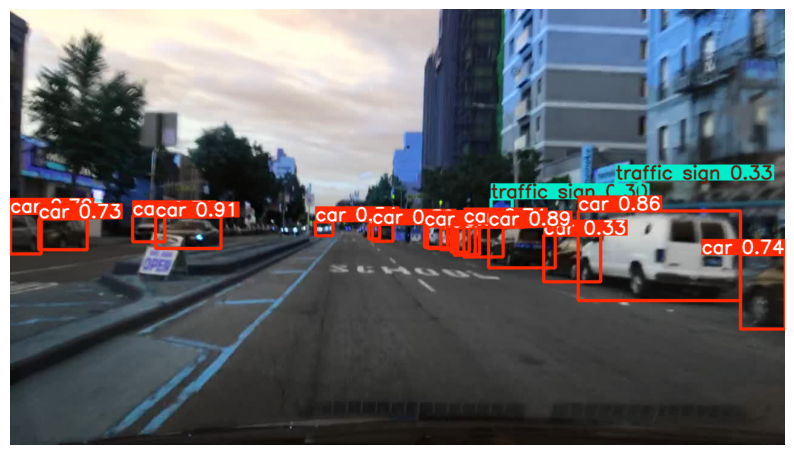

In [76]:
#Test prediction
# Load the model
model1 = YOLO(f"{project_path}/model_1/weights/best.pt")
# Run inference on a test image
results = model1("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)

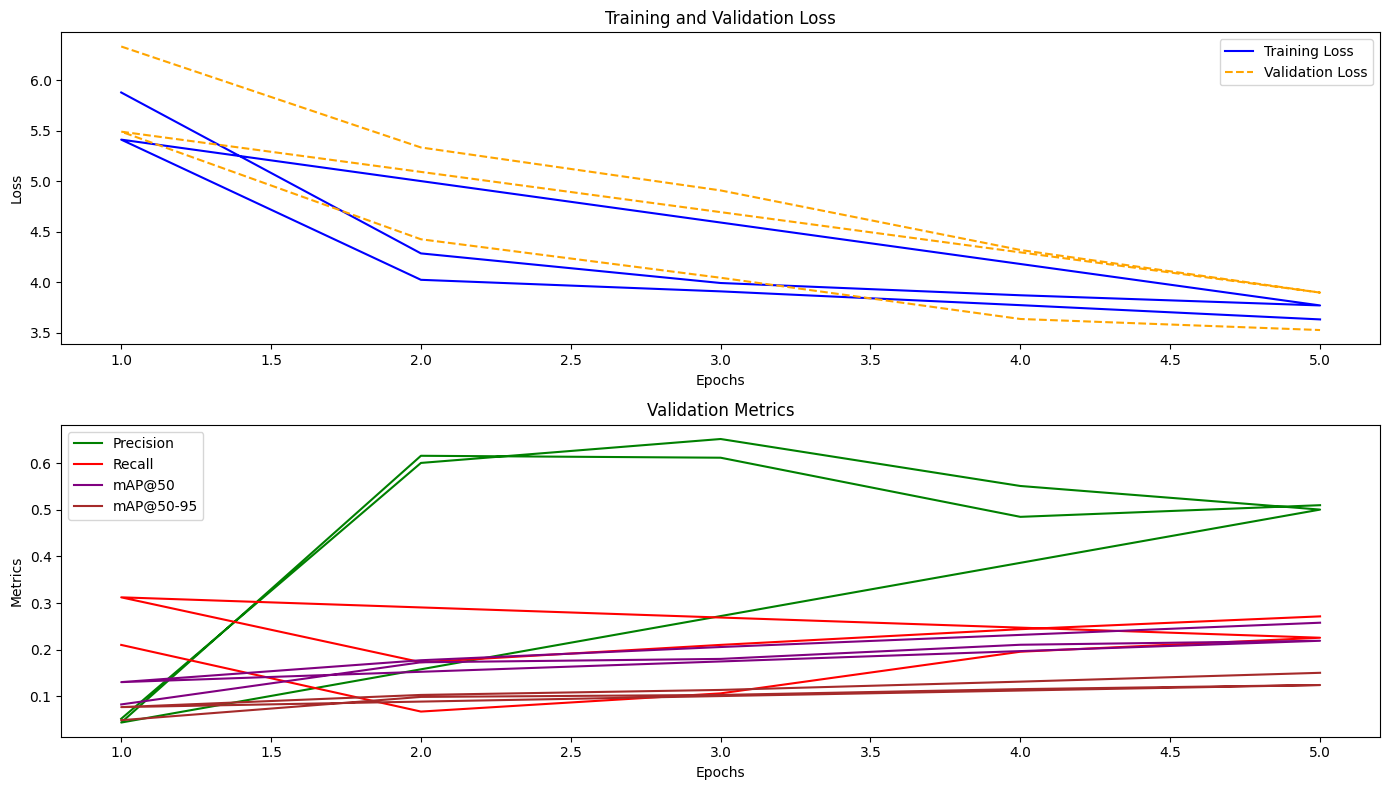

In [74]:
mt.plot_yolo_metrics(f"{project_path}/model_1/results.csv")

## Experimental Models

### Pre-trained YOLO Model with Lower Batch SIZE

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
model2 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model2.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=5,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=16,              # Set batch size (e.g., 8) to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_2", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.689      2.323      1.107        491        640: 100%|██████████| 125/125 [08:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:31


                   all       1500      25316      0.579      0.175      0.165     0.0926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G       1.56      1.399      1.067        445        640: 100%|██████████| 125/125 [08:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:29


                   all       1500      25316      0.575      0.213      0.191      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.543       1.31      1.058        378        640: 100%|██████████| 125/125 [08:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316       0.59      0.216      0.212      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.508      1.228      1.046        324        640: 100%|██████████| 125/125 [08:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316      0.625      0.242      0.248      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.457      1.156      1.029        622        640: 100%|██████████| 125/125 [08:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316      0.461      0.259       0.25      0.144

5 epochs completed in 0.809 hours.
Optimizer stripped from runs\train\finetuned_model2\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model2\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model2\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:08


                   all       1500      25316      0.461      0.258      0.251      0.144
                   car       1484      15066      0.593      0.588      0.616      0.364
                 truck        395        634      0.456      0.273      0.251      0.158
                   bus        171        206      0.254      0.393      0.306      0.243
         traffic light        854       4111      0.469       0.23      0.237     0.0773
          traffic sign       1225       5222      0.451      0.323      0.302      0.146
                 train          2          2          1          0          0          0
                 rider         61         75          0          0     0.0422     0.0191
Speed: 0.9ms preprocess, 34.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\train\finetuned_model2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000181F951A330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [77]:
# Load the fine-tuned model
model_2 = YOLO(f"{project_path}/model_2/weights/best.pt")


# Run inference on a test image
results = model_2("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)



FileNotFoundError: [Errno 2] No such file or directory: 'runs\\train\\model_2\\weights\\best.pt'

### Increasing Epoch Size from 5 to 10

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model3 = YOLO(f"{project_path}model_1/weights/best.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model3.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_3", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=runs/train/finetuned_model/weights/best.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model3, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.486      1.254      1.034        250        640: 100%|██████████| 63/63 [08:47<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:51


                   all       1500      25316      0.461      0.262      0.241      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.502      1.222      1.039        287        640: 100%|██████████| 63/63 [08:37<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:37


                   all       1500      25316      0.522      0.245      0.242      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.514      1.206      1.045        261        640: 100%|██████████| 63/63 [08:29<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316       0.29      0.239      0.206      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.521      1.178      1.048        263        640: 100%|██████████| 63/63 [08:30<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:36


                   all       1500      25316      0.358      0.263      0.247      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.501      1.127       1.04        309        640: 100%|██████████| 63/63 [08:30<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:39


                   all       1500      25316      0.414      0.257       0.25      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.469      1.084      1.028        277        640: 100%|██████████| 63/63 [08:32<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:37


                   all       1500      25316      0.362      0.288      0.266      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.451      1.044       1.02        287        640: 100%|██████████| 63/63 [08:27<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:36


                   all       1500      25316      0.398      0.269      0.267      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.433      1.019      1.011        261        640: 100%|██████████| 63/63 [08:26<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.394      0.284      0.278      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.407     0.9857      1.002        268        640: 100%|██████████| 63/63 [08:23<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.434      0.304      0.292      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.397     0.9596     0.9974        238        640: 100%|██████████| 63/63 [08:25<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.419      0.299      0.302      0.174

10 epochs completed in 1.711 hours.
Optimizer stripped from runs\train\finetuned_model3\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model3\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model3\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:13


                   all       1500      25316      0.433      0.294      0.302      0.174
                   car       1484      15066      0.609      0.615      0.641      0.381
                 truck        395        634      0.511      0.329      0.351      0.241
                   bus        171        206      0.361      0.374      0.332      0.263
         traffic light        854       4111      0.506      0.296      0.303        0.1
          traffic sign       1225       5222      0.576      0.322      0.349      0.172
                 train          2          2          0          0          0          0
                 rider         61         75      0.464       0.12      0.138     0.0586
Speed: 1.4ms preprocess, 37.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\train\finetuned_model3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001820BAD6060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 22 cars, 3 traffic signs, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


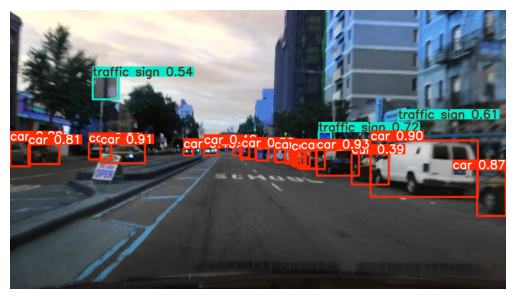

In [ ]:
# Load the fine-tuned model
model_3 = YOLO(f"{project_path}/model_3/weights/best.pt")

# Run inference on a test image
results = model_3("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


### Using 8s model instead of 8n

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model4 = YOLO("yolov8s.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model4.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_4", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


100%|██████████████████████████████████████████████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 116MB/s]


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model4, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.61      2.465      1.114        254        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:24


                   all       1500      25316      0.629      0.225      0.229      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.496       1.17      1.057        281        640: 100%|██████████| 63/63 [20:40<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.463      0.282      0.247       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.466      1.062      1.042        255        640: 100%|██████████| 63/63 [21:33<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316       0.32      0.268      0.237      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.463      1.032      1.049        258        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06


                   all       1500      25316      0.389      0.289      0.282      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.443     0.9762      1.034        306        640: 100%|██████████| 63/63 [19:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.389      0.307       0.29      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G        1.4     0.9317      1.018        269        640: 100%|██████████| 63/63 [19:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316       0.42      0.316      0.314      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.381     0.8927      1.011        289        640: 100%|██████████| 63/63 [20:30<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316      0.481      0.329      0.337      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.347     0.8506     0.9959        263        640: 100%|██████████| 63/63 [21:06<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316       0.46       0.33      0.346      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.322     0.8175     0.9862        261        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316      0.501      0.339      0.357      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.302     0.7887     0.9808        245        640: 100%|██████████| 63/63 [20:39<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.491      0.349      0.371      0.216

10 epochs completed in 3.938 hours.
Optimizer stripped from runs\train\finetuned_model4\weights\last.pt, 22.5MB
Optimizer stripped from runs\train\finetuned_model4\weights\best.pt, 22.5MB

Validating runs\train\finetuned_model4\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:33


                   all       1500      25316       0.49      0.349      0.371      0.216
                   car       1484      15066      0.676      0.652      0.691       0.42
                 truck        395        634      0.615      0.371      0.446      0.305
                   bus        171        206      0.537      0.442      0.417      0.324
         traffic light        854       4111      0.596      0.371      0.395      0.138
          traffic sign       1225       5222      0.651      0.392      0.449       0.23
                 train          2          2          0          0          0          0
                 rider         61         75      0.355      0.213        0.2      0.096
Speed: 1.6ms preprocess, 91.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\train\finetuned_model4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024EEA73C950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 18 cars, 2 traffic lights, 2 traffic signs, 169.7ms
Speed: 8.0ms preprocess, 169.7ms inference, 20.0ms postprocess per image at shape (1, 3, 384, 640)


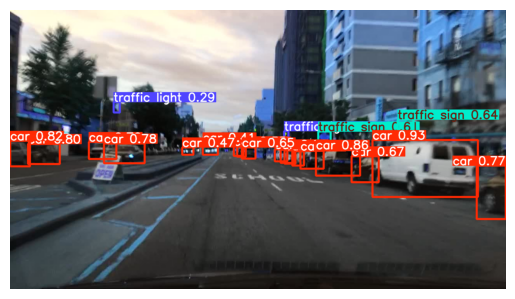

In [ ]:
# Load the fine-tuned model
model_4 = YOLO(f"{project_path}/model_4/weights/best.pt")


# Run inference on a test image
results = model_4("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


### Training Model with FREEZED backbone layers (feature extraction layers)

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model5 = YOLO("yolov8s.pt")


# Train the model with the updated syntax
model5.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=100,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_5", # Folder name for saving the model
    exist_ok=True,         # Overwrite existing run folder
    workers=6,             # Number of data loading workers
    save_period=2,         # Save model every 2 epochs
    verbose=False,          # Suppress verbose output
    freeze =10
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model5, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.588      2.164      1.111        534        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06


                   all       1500      25316      0.597      0.247      0.248      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.462      1.145       1.05        469        640: 100%|██████████| 63/63 [11:56<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.428      0.274      0.276      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.461      1.081      1.047        410        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:01


                   all       1500      25316      0.435      0.303       0.29       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.459      1.048      1.049        352        640: 100%|██████████| 63/63 [12:02<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316       0.46      0.295      0.304      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.431      1.003      1.034        603        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316       0.42      0.294      0.298      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.406     0.9771      1.026        477        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.459      0.297      0.299      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.404     0.9545      1.027        536        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.427      0.317      0.308       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.398     0.9549      1.021        398        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.463      0.327      0.334       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.391     0.9264      1.016        569        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:00


                   all       1500      25316      0.456      0.313      0.325      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.382     0.9128      1.012        377        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.591       0.34      0.325      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.373     0.9008      1.007        377        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.559      0.331      0.325       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.371     0.8927      1.012        399        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316       0.61       0.34      0.336      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.357     0.8835      1.003        667        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.585      0.326      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.339     0.8681     0.9974        382        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.609      0.329      0.341      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.331     0.8579     0.9976        345        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.553      0.328      0.335      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.335     0.8512     0.9983        489        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.595      0.335      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.334     0.8429     0.9906        473        640: 100%|██████████| 63/63 [11:46<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.602      0.334      0.346      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.304      0.825     0.9894        580        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.599      0.328      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.309     0.8244     0.9869        435        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.611      0.344      0.353      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.315     0.8207     0.9863        526        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57


                   all       1500      25316      0.607      0.341      0.345      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.308     0.8172     0.9861        402        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.627       0.32      0.349      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.303     0.8015     0.9823        486        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.601      0.327      0.336      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G        1.3     0.8023      0.981        581        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.601      0.339      0.345      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.295     0.7936     0.9796        411        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.646      0.328      0.353      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.281     0.7865     0.9741        471        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.607      0.339      0.351      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.287     0.7911     0.9758        559        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316       0.57      0.337      0.335       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.292     0.7864     0.9735        419        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.581      0.336      0.342      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.278      0.776     0.9708        288        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.591      0.338      0.336      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.278     0.7741     0.9719        366        640: 100%|██████████| 63/63 [11:46<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.588      0.337      0.335       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.286     0.7793     0.9713        535        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.615      0.347      0.355      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.267     0.7652      0.971        409        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316       0.59       0.35      0.351      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.281     0.7764     0.9705        767        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.622      0.332      0.351      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.262     0.7573     0.9672        378        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.612      0.347      0.354      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.253     0.7541     0.9646        415        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.622      0.349      0.353      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.263     0.7588     0.9669        558        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.627       0.35       0.36      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.251     0.7435      0.962        425        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.621      0.345      0.358      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.247     0.7436     0.9593        411        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.651      0.333      0.351      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.247     0.7375     0.9613        492        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57

                   all       1500      25316      0.587      0.351      0.356      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G       1.26     0.7484     0.9672        500        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.618      0.344      0.353      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.237     0.7289     0.9587        296        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.631      0.346      0.359      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.239     0.7334     0.9586        453        640: 100%|██████████| 63/63 [11:44<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.623      0.352      0.354      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.235     0.7316      0.953        577        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57

                   all       1500      25316      0.616      0.348      0.348      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.227     0.7244     0.9542        432        640: 100%|██████████| 63/63 [11:56<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:01

                   all       1500      25316      0.633      0.354      0.359        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.229     0.7213     0.9511        382        640: 100%|██████████| 63/63 [12:26<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:24


                   all       1500      25316      0.633      0.345      0.363      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.227     0.7181      0.948        600        640: 100%|██████████| 63/63 [13:31<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:26


                   all       1500      25316      0.651      0.341      0.359      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.229     0.7147     0.9523        475        640: 100%|██████████| 63/63 [13:52<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:34


                   all       1500      25316      0.628      0.349      0.359      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.213     0.7108       0.95        490        640: 100%|██████████| 63/63 [12:57<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.648      0.325      0.345      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.227     0.7107     0.9537        526        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316       0.62      0.338      0.348      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.222     0.7143     0.9505        516        640: 100%|██████████| 63/63 [12:47<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13

                   all       1500      25316      0.622      0.344      0.357      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.219     0.7047     0.9471        710        640: 100%|██████████| 63/63 [12:44<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.601      0.341      0.341      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.208     0.7023     0.9433        449        640: 100%|██████████| 63/63 [13:08<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:19


                   all       1500      25316      0.593      0.349      0.354      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.214     0.6995     0.9453        379        640: 100%|██████████| 63/63 [13:33<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:16


                   all       1500      25316      0.621      0.344      0.353      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.196     0.6942     0.9434        412        640: 100%|██████████| 63/63 [13:07<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:16


                   all       1500      25316      0.616      0.348      0.354      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.211      0.698     0.9449        646        640: 100%|██████████| 63/63 [13:00<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:18


                   all       1500      25316      0.647      0.333       0.36      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.202     0.6922     0.9455        473        640: 100%|██████████| 63/63 [13:11<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:20


                   all       1500      25316      0.618      0.347      0.357      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.197     0.6901     0.9457        533        640: 100%|██████████| 63/63 [13:01<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:14


                   all       1500      25316      0.621      0.336      0.349      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.205     0.6856      0.945        506        640: 100%|██████████| 63/63 [13:14<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:14


                   all       1500      25316      0.621      0.348      0.361      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G        1.2     0.6868     0.9447        422        640: 100%|██████████| 63/63 [13:23<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:20


                   all       1500      25316      0.637      0.352      0.365      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.205     0.6916     0.9446        530        640: 100%|██████████| 63/63 [12:58<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.504      0.341      0.363      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.187     0.6803     0.9381        424        640: 100%|██████████| 63/63 [15:14<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:07


                   all       1500      25316      0.663      0.334      0.359      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.176      0.677     0.9376        494        640: 100%|██████████| 63/63 [13:13<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316      0.645      0.347      0.362      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.186       0.68     0.9378        551        640: 100%|██████████| 63/63 [12:52<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.627      0.338      0.362        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.178     0.6727     0.9381        437        640: 100%|██████████| 63/63 [12:49<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:27


                   all       1500      25316      0.634      0.333       0.36      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.194       0.68     0.9408        453        640: 100%|██████████| 63/63 [13:00<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.649      0.345      0.365      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.174     0.6686     0.9348        520        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.645      0.346       0.36        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.188     0.6719     0.9406        462        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.645      0.343      0.363      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.173     0.6694     0.9353        489        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.663      0.342      0.365      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.174     0.6691     0.9347        501        640: 100%|██████████| 63/63 [12:35<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.645      0.351      0.367      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.173     0.6595     0.9343        418        640: 100%|██████████| 63/63 [12:31<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.628      0.348      0.368      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.172     0.6621     0.9309        426        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.614      0.352      0.359      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.168     0.6596     0.9291        592        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.609      0.349      0.357      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.165     0.6583     0.9304        500        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316       0.67      0.335      0.367      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.161     0.6568     0.9323        438        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316       0.63      0.357      0.367      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.159     0.6546      0.932        521        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.635      0.356      0.369      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.166     0.6548     0.9316        381        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12

                   all       1500      25316      0.635      0.341      0.359      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G       1.17      0.655      0.936        432        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06

                   all       1500      25316      0.623       0.36      0.366      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.161     0.6482     0.9323        446        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.638      0.355      0.368      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.158     0.6511     0.9299        519        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.637      0.353      0.367      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.156     0.6472     0.9298        496        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.617      0.349      0.363      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.156     0.6463      0.928        369        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.482       0.36      0.364      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.147     0.6459     0.9252        596        640: 100%|██████████| 63/63 [12:31<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.616      0.355      0.364      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G       1.15     0.6404     0.9232        485        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.633       0.35      0.367      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.146     0.6404     0.9267        543        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.505       0.35      0.366      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.143     0.6385     0.9276        464        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.632      0.353       0.37      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.147     0.6371     0.9289        429        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.633      0.358      0.369      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.136     0.6325      0.921        586        640: 100%|██████████| 63/63 [12:40<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:11

                   all       1500      25316      0.644      0.353      0.366        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.143      0.632     0.9242        386        640: 100%|██████████| 63/63 [13:09<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:25


                   all       1500      25316      0.653      0.351      0.366      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.124     0.6247     0.9186        461        640: 100%|██████████| 63/63 [13:17<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.635      0.348      0.363        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.139     0.6254      0.923        534        640: 100%|██████████| 63/63 [12:40<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.658      0.348      0.364      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.135     0.6288     0.9235        535        640: 100%|██████████| 63/63 [13:23<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:23


                   all       1500      25316      0.656      0.344      0.364      0.201
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.272     0.7428     0.9595        271        640: 100%|██████████| 63/63 [12:47<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:11


                   all       1500      25316       0.61      0.334      0.339      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.258     0.7245      0.955        223        640: 100%|██████████| 63/63 [13:12<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.465      0.329      0.332      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.241     0.7048     0.9491        255        640: 100%|██████████| 63/63 [12:07<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316       0.62      0.328      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.246     0.7036     0.9526        282        640: 100%|██████████| 63/63 [12:06<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.615      0.324      0.339      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.239     0.7022     0.9446        251        640: 100%|██████████| 63/63 [12:10<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.616      0.325       0.34      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      1.236     0.6918     0.9468        229        640: 100%|██████████| 63/63 [12:04<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316      0.621      0.327      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.231     0.6948     0.9431        176        640: 100%|██████████| 63/63 [12:06<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.601      0.326       0.34      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.233     0.6938     0.9442        278        640: 100%|██████████| 63/63 [12:28<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.602      0.332      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.228     0.6887     0.9414        317        640: 100%|██████████| 63/63 [14:46<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:56


                   all       1500      25316      0.597      0.338      0.345      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G       1.23       0.69     0.9469        242        640: 100%|██████████| 63/63 [18:56<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:00


                   all       1500      25316      0.599      0.339      0.345      0.192

100 epochs completed in 26.089 hours.
Optimizer stripped from runs\train\finetuned_model5\weights\last.pt, 22.5MB
Optimizer stripped from runs\train\finetuned_model5\weights\best.pt, 22.5MB

Validating runs\train\finetuned_model5\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:04


                   all       1500      25316      0.632      0.353      0.369      0.205
Speed: 2.3ms preprocess, 143.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\train\finetuned_model5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000015719F721B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
# Load the fine-tuned model
model_5 = YOLO(f"{project_path}/model_5/weights/best.pt")

# Run inference on a test image
results = model_5("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


### Training Model with 100k images

#### Training using CPU only

In [ ]:
#model 6

#### Training with GPU

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
model7 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model7.train(
    data=dataset1_path,
    epochs=5,
    imgsz=640,
    batch=16,
    project=project_path,
    name="model_7",
    exist_ok=True,
    device=0,  # Ensures GPU is used
    half=True  # Enables FP16 training
)



Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/dataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/train, name=finetuned_model2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /content/dataset/labels/train... 69863 images, 151 backgrounds, 0 corrupt: 100%|██████████| 70000/70000 [01:45<00:00, 662.96it/s]

train: WARNING ⚠️ /content/dataset/images/train/75055858-7d04a650.jpg: 1 duplicate labels removed


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/labels/val... 10000 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:17<00:00, 564.07it/s]


val: New cache created: /content/dataset/labels/val.cache
Plotting labels to runs/train/finetuned_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/finetuned_model2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G      1.463       1.26      1.037        468        640: 100%|██████████| 4375/4375 [26:23<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]


                   all      10000     170805      0.575      0.304      0.307      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.36G      1.388     0.9379      1.014        384        640: 100%|██████████| 4375/4375 [25:54<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


                   all      10000     170805      0.609      0.332      0.349      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       3.8G      1.361     0.8937      1.005        400        640: 100%|██████████| 4375/4375 [26:25<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:39<00:00,  3.15it/s]


                   all      10000     170805      0.634      0.354      0.378      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.334     0.8555     0.9946        626        640: 100%|██████████| 4375/4375 [26:35<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:39<00:00,  3.15it/s]


                   all      10000     170805      0.653      0.366      0.396      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.303     0.8177     0.9833        383        640: 100%|██████████| 4375/4375 [26:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


                   all      10000     170805      0.671      0.372      0.409      0.236

5 epochs completed in 2.341 hours.
Optimizer stripped from runs/train/finetuned_model2/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/finetuned_model2/weights/best.pt, 6.2MB

Validating runs/train/finetuned_model2/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


                   all      10000     170805      0.669      0.373      0.408      0.236
                   car       9879     102506      0.714       0.65      0.703      0.429
                 truck       2689       4245      0.586      0.472      0.509      0.358
                   bus       1242       1597      0.601      0.427      0.479      0.366
         traffic light       5653      26885      0.609      0.408      0.435      0.151
          traffic sign       8221      34908      0.651      0.431      0.487      0.243
                 train         14         15          1          0          0          0
                 rider        515        649      0.524      0.222      0.246      0.107
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/train/finetuned_model2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79de577c6b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
# Load the fine-tuned model
model_7 = YOLO(f"{project_path}/model_7/weights/best.pt")

# Run inference on a test image
results = model_7("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


### Balance vs Unbalanced Dataset

In [ ]:
# 1500 random images (unbalanced not handpicked)

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model8 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model8.train(
    data=dataset3_path,  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_8", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset2.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model6, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 834.45it/s]


train: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train.cache


val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 902.52it/s]


val: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val.cache
Plotting labels to runs\train\finetuned_model6\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.957      2.298      1.265        180        640: 100%|██████████| 32/32 [03:03<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:53<00:00,  6.67s/it]

                   all        500       8446      0.186      0.117     0.0486     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       2.02      1.694      1.324        172        640: 100%|██████████| 32/32 [02:55<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.72s/it]

                   all        500       8446      0.258      0.136     0.0633     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.952      1.547      1.291        180        640: 100%|██████████| 32/32 [02:54<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:41<00:00,  5.21s/it]

                   all        500       8446      0.134      0.172     0.0892       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.887      1.465      1.262        127        640: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.39s/it]

                   all        500       8446      0.321      0.157      0.103     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.809       1.38      1.232        122        640: 100%|██████████| 32/32 [02:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:34<00:00,  4.30s/it]

                   all        500       8446       0.32      0.154      0.119     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.761      1.309       1.19        122        640: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.20s/it]

                   all        500       8446      0.375      0.188      0.156     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.712      1.269      1.174        121        640: 100%|██████████| 32/32 [02:55<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.12s/it]

                   all        500       8446      0.403      0.202      0.171     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.681      1.225      1.166        140        640: 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.17s/it]

                   all        500       8446      0.414      0.207      0.177     0.0931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.64      1.179      1.144        135        640: 100%|██████████| 32/32 [02:55<00:00,  5.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.15s/it]

                   all        500       8446      0.417      0.216      0.183     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.605      1.141      1.124        163        640: 100%|██████████| 32/32 [02:55<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.18s/it]

                   all        500       8446      0.412      0.223      0.189        0.1



10 epochs completed in 0.595 hours.
Optimizer stripped from runs\train\finetuned_model6\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model6\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model6\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


                   all        500       8446      0.412      0.223      0.189        0.1
Speed: 1.5ms preprocess, 39.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\train\finetuned_model6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000169CBE456D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
# Load the fine-tuned model
model_8 = YOLO(f"{project_path}/model_8/weights/best.pt")

# Run inference on a test image
results = model_8("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


In [ ]:
# 1500 images (handpicked)

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model9 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model9.train(
    data=dataset4_path,  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_9", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True        # Overwrite existing run folder
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset3.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model8, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500_2\labels\train.cache... 999 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500_2\labels\val.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

Plotting labels to runs\train\finetuned_model8\labels.jpg... 


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model8
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.894      2.405      1.287        104        640: 100%|██████████| 32/32 [03:05<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:52<00:00,  6.58s/it]

                   all        500      10334      0.323      0.168     0.0595     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.941       1.73      1.343        131        640: 100%|██████████| 32/32 [03:03<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:02<00:00,  7.77s/it]

                   all        500      10334       0.14      0.354      0.118     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.889      1.587      1.307        153        640: 100%|██████████| 32/32 [03:03<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]

                   all        500      10334      0.211      0.243      0.126      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.844      1.507      1.282        122        640: 100%|██████████| 32/32 [03:03<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.37s/it]

                   all        500      10334      0.283      0.263      0.177     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.79      1.455      1.259        115        640: 100%|██████████| 32/32 [03:03<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.70s/it]

                   all        500      10334      0.328      0.318      0.225      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.706      1.355      1.212         88        640: 100%|██████████| 32/32 [03:03<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.50s/it]

                   all        500      10334      0.386      0.322      0.263      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.692      1.313        1.2        135        640: 100%|██████████| 32/32 [03:02<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.47s/it]

                   all        500      10334      0.404      0.354        0.3      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.635       1.25      1.176        153        640: 100%|██████████| 32/32 [03:03<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.46s/it]

                   all        500      10334      0.441       0.35      0.319      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.596       1.21      1.155        117        640: 100%|██████████| 32/32 [03:02<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.50s/it]

                   all        500      10334      0.477      0.357      0.341      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G       1.58      1.182      1.153        110        640: 100%|██████████| 32/32 [03:03<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:36<00:00,  4.54s/it]

                   all        500      10334      0.467      0.362      0.344       0.19



10 epochs completed in 0.628 hours.
Optimizer stripped from runs\train\finetuned_model8\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model8\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model8\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:27<00:00,  3.46s/it]


                   all        500      10334      0.467      0.362      0.344       0.19
Speed: 1.4ms preprocess, 41.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\train\finetuned_model8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000169E51D8770>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [ ]:
model_9 = YOLO(f"{project_path}/model_9/weights/best.pt")

# Run inference on a test image
results = model_9("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)

### Data Augmentation

In [ ]:
# data augmented

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model10 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model10.train(
    data=dataset4_path,  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project=project_path, # Directory where training results will be saved
    name="model_10", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True,        # Overwrite existing run folder
    augment=True,
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset4.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model9, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

Plotting labels to runs\train\finetuned_model9\labels.jpg... 


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.957      2.298      1.265        180        640: 100%|██████████| 32/32 [02:55<00:00,  5.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:52<00:00,  6.55s/it]

                   all        500       8446      0.186      0.117     0.0486     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       2.02      1.694      1.324        172        640: 100%|██████████| 32/32 [02:55<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.69s/it]

                   all        500       8446      0.258      0.136     0.0633     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.952      1.547      1.291        180        640: 100%|██████████| 32/32 [02:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.26s/it]

                   all        500       8446      0.134      0.172     0.0892       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.887      1.465      1.262        127        640: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]

                   all        500       8446      0.321      0.157      0.103     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.809       1.38      1.232        122        640: 100%|██████████| 32/32 [02:55<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:34<00:00,  4.26s/it]

                   all        500       8446       0.32      0.154      0.119     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.761      1.309       1.19        122        640: 100%|██████████| 32/32 [02:54<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.17s/it]

                   all        500       8446      0.375      0.188      0.156     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.712      1.269      1.174        121        640: 100%|██████████| 32/32 [02:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.11s/it]

                   all        500       8446      0.403      0.202      0.171     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.681      1.225      1.166        140        640: 100%|██████████| 32/32 [02:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.13s/it]

                   all        500       8446      0.414      0.207      0.177     0.0931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.64      1.179      1.144        135        640: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.11s/it]

                   all        500       8446      0.417      0.216      0.183     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.605      1.141      1.124        163        640: 100%|██████████| 32/32 [02:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.12s/it]

                   all        500       8446      0.412      0.223      0.189        0.1



10 epochs completed in 0.591 hours.
Optimizer stripped from runs\train\finetuned_model9\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model9\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model9\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


                   all        500       8446      0.425       0.21      0.185      0.102
Speed: 1.1ms preprocess, 89.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\train\finetuned_model9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000169CC0E3140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
# Load the fine-tuned model
model_10 = YOLO(f"{project_path}/model_10/weights/best.pt")

# Run inference on a test image
results = model_10("dataset1/images/val/b1c66a42-6f7d68ca.jpg")

mt.display_results(results)


### Hyperparameter Combinations

#### Overriding Auto-assigned Metrics

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model11 = YOLO("yolov8s.pt")

# Train with Early Stopping
model11.train(
    data=dataset1_path,       # Dataset configuration
    epochs=50,                 # Total epochs
    patience=5,                # Stop if no improvement after 5 epochs
    imgsz=640,                 # Image size
    batch=32,                  # Batch size
    project=project_path,      # Output directory
    name="model_11",    # Experiment name
    exist_ok=True,              # Overwrite existing runs
    freeze = 10,
    cls=1.5,
    lr0=0.01,             # Initial learning rate
    lrf=0.01,
    save_period=2,
    optimizer="Adam",
    cos_lr = True,
)


New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/dataset.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=8, project=/content/drive/My Drive/FinalProjectRuntimeruns/train, name=finetuned_model, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, reti

train: Scanning /content/dataset/labels/train.cache... 69863 images, 151 backgrounds, 0 corrupt: 100%|██████████| 70000/70000 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/images/train/75055858-7d04a650.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val.cache... 10000 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]


Plotting labels to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.3G      1.486      3.146       1.07        484        640: 100%|██████████| 2188/2188 [04:47<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.432      0.314      0.313      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.35G      1.459      2.864      1.068        382        640: 100%|██████████| 2188/2188 [04:35<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


                   all      10000     170805      0.614      0.344      0.354      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.19G      1.449       2.82      1.065        489        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.613      0.347      0.359      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.81G      1.445      2.805      1.064        440        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.627      0.351      0.368      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       7.2G      1.437      2.774      1.059        456        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.636      0.356      0.375      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       8.1G       1.43       2.75      1.055        470        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


                   all      10000     170805      0.511      0.355      0.383      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.43G      1.425      2.735      1.052        479        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805      0.635      0.367      0.387      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       6.1G      1.419      2.714      1.048        484        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.647      0.364      0.389      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.17G      1.415      2.703      1.046        413        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


                   all      10000     170805      0.647       0.37      0.394      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.42G       1.41      2.679      1.044        442        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


                   all      10000     170805      0.652      0.373      0.394      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.78G       1.41      2.683      1.043        485        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]


                   all      10000     170805      0.657      0.372      0.397      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.08G      1.403      2.665      1.041        594        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.659       0.37      0.398      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.25G      1.401      2.659      1.039        554        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.663      0.371      0.399      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.39G      1.399      2.652      1.038        458        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805       0.66      0.374      0.401      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.87G      1.396      2.639      1.037        518        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.661      0.374      0.402      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.23G      1.392      2.633      1.036        318        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


                   all      10000     170805      0.663      0.372      0.402      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.14G      1.389      2.622      1.033        547        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


                   all      10000     170805      0.669      0.372      0.402      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.29G      1.389      2.617      1.034        440        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.669      0.373      0.403      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.95G      1.387       2.61      1.033        531        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.671      0.373      0.404      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.16G      1.382      2.596      1.031        415        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]


                   all      10000     170805      0.669      0.375      0.405      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.73G      1.379      2.587      1.029        423        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


                   all      10000     170805      0.669      0.376      0.406       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       7.1G      1.376      2.577      1.028        564        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805       0.67      0.376      0.406       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.58G      1.373      2.568      1.027        500        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


                   all      10000     170805      0.672      0.374      0.407      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.75G      1.367      2.557      1.025        396        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.668      0.376      0.407      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.05G      1.365      2.547      1.024        486        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805       0.67      0.376      0.408      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.2G      1.361      2.537      1.022        539        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.671      0.375      0.409      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         7G      1.359      2.527      1.021        539        640: 100%|██████████| 2188/2188 [04:32<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:42<00:00,  3.72it/s]


                   all      10000     170805      0.673      0.375       0.41      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.83G      1.355      2.516       1.02        558        640: 100%|██████████| 2188/2188 [04:31<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:42<00:00,  3.73it/s]


                   all      10000     170805      0.673      0.377      0.411      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.02G      1.352      2.502      1.018        504        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.669      0.379      0.412      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.65G      1.348      2.497      1.017        523        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


                   all      10000     170805       0.67      0.379      0.412      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.07G      1.344      2.485      1.015        523        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805       0.67       0.38      0.413      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       7.5G      1.338      2.469      1.013        406        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805      0.671      0.381      0.414      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.43G      1.338      2.459      1.013        516        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]


                   all      10000     170805      0.672      0.382      0.415      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.6G      1.334      2.443       1.01        593        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.671      0.384      0.416      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.41G       1.33      2.434      1.009        496        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]


                   all      10000     170805      0.674      0.381      0.416      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.93G      1.324      2.421      1.007        441        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805      0.672      0.382      0.417      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.63G      1.319      2.404      1.005        555        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.675      0.383      0.418      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.88G      1.316       2.39      1.003        505        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


                   all      10000     170805      0.675      0.383      0.418       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.43G      1.312      2.382      1.003        494        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.674      0.386       0.42      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.98G      1.308      2.366      1.001        668        640: 100%|██████████| 2188/2188 [04:22<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.672      0.387       0.42      0.241
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.07G      1.364      2.451      1.012        215        640: 100%|██████████| 2188/2188 [04:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]


                   all      10000     170805      0.671      0.386       0.42      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.06G      1.355      2.417      1.009        275        640: 100%|██████████| 2188/2188 [04:10<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.671      0.385      0.419      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.03G      1.349      2.397      1.006        239        640: 100%|██████████| 2188/2188 [04:09<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


                   all      10000     170805      0.675      0.382      0.419      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.98G      1.344       2.38      1.004        174        640: 100%|██████████| 2188/2188 [04:10<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.91it/s]


                   all      10000     170805      0.675      0.382      0.419      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.34G      1.339      2.361      1.002        251        640: 100%|██████████| 2188/2188 [04:10<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


                   all      10000     170805      0.672      0.381      0.418      0.241
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

45 epochs completed in 3.839 hours.
Optimizer stripped from /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model/weights/best.pt, 22.5MB

Validating /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]


                   all      10000     170805      0.674      0.386       0.42      0.241
                   car       9879     102506      0.662      0.667        0.7      0.425
                 truck       2689       4245      0.594       0.48      0.514      0.359
                   bus       1242       1597      0.573      0.466      0.495      0.372
         traffic light       5653      26885      0.598      0.411      0.439      0.155
          traffic sign       8221      34908      0.674      0.457      0.519      0.262
                 train         14         15          1          0          0          0
                 rider        515        649      0.614      0.223      0.275      0.117
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79fc9a69cf40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:


from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model12 = YOLO("yolov8n.pt")

# Train the model with a learning rate scheduler
model12.train(
    data=dataset2_path,  # Path to your custom dataset.yaml file
    epochs=25,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project=project_path, # Directory where training results will be saved
    name="mddel_12", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model7, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
val: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]


Plotting labels to runs\train\finetuned_model7\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model7
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.843      1.964      1.201        534        640: 100%|██████████| 63/63 [06:41<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:51<00:00,  4.65s/it]


                   all       1500      25316      0.082      0.174     0.0452     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.817       1.46      1.213        469        640: 100%|██████████| 63/63 [06:36<00:00,  6.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:46<00:00,  4.46s/it]


                   all       1500      25316      0.331      0.167      0.118     0.0551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G       1.79      1.384      1.197        410        640: 100%|██████████| 63/63 [06:39<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:52<00:00,  4.68s/it]


                   all       1500      25316       0.44      0.173     0.0992       0.05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.748      1.331      1.176        352        640: 100%|██████████| 63/63 [06:38<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:48<00:00,  4.51s/it]


                   all       1500      25316      0.367      0.184      0.141       0.07

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.717      1.281       1.16        603        640: 100%|██████████| 63/63 [06:35<00:00,  6.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


                   all       1500      25316      0.371      0.212      0.169     0.0861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.668       1.24      1.141        477        640: 100%|██████████| 63/63 [06:36<00:00,  6.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.46s/it]


                   all       1500      25316      0.414      0.222      0.188     0.0961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.652      1.211      1.133        536        640: 100%|██████████| 63/63 [06:37<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


                   all       1500      25316      0.405      0.225      0.186     0.0953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.647      1.206      1.131        398        640: 100%|██████████| 63/63 [06:27<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:40<00:00,  4.18s/it]


                   all       1500      25316      0.417      0.237      0.194        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.627      1.174      1.121        569        640: 100%|██████████| 63/63 [06:18<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:40<00:00,  4.19s/it]


                   all       1500      25316      0.412      0.214      0.187     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.599      1.159      1.104        377        640: 100%|██████████| 63/63 [06:19<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:40<00:00,  4.18s/it]


                   all       1500      25316      0.278      0.241      0.207      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G       1.58      1.126      1.101        377        640: 100%|██████████| 63/63 [06:21<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:42<00:00,  4.27s/it]


                   all       1500      25316      0.434      0.255      0.218      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.589      1.124      1.107        399        640: 100%|██████████| 63/63 [06:19<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:39<00:00,  4.16s/it]


                   all       1500      25316      0.565      0.239      0.213      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.572      1.113      1.098        667        640: 100%|██████████| 63/63 [06:26<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:45<00:00,  4.40s/it]


                   all       1500      25316      0.479      0.263      0.226      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.536      1.077      1.081        382        640: 100%|██████████| 63/63 [06:30<00:00,  6.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


                   all       1500      25316      0.313      0.266      0.228      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.517      1.061      1.081        345        640: 100%|██████████| 63/63 [06:32<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:46<00:00,  4.46s/it]


                   all       1500      25316      0.456      0.268      0.236      0.126
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.555      1.085      1.082        313        640: 100%|██████████| 63/63 [06:11<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:45<00:00,  4.40s/it]


                   all       1500      25316      0.503      0.265      0.229      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G       1.55       1.06       1.08        294        640: 100%|██████████| 63/63 [06:08<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:49<00:00,  4.56s/it]


                   all       1500      25316      0.491      0.265      0.236      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.525      1.037       1.07        257        640: 100%|██████████| 63/63 [06:10<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.48s/it]


                   all       1500      25316      0.485      0.256      0.232      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.521      1.018      1.062        236        640: 100%|██████████| 63/63 [06:09<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:44<00:00,  4.34s/it]


                   all       1500      25316      0.476      0.262      0.234      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.507      1.004      1.063        205        640: 100%|██████████| 63/63 [05:59<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:44<00:00,  4.35s/it]


                   all       1500      25316      0.485      0.264      0.239      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.495     0.9924      1.054        262        640: 100%|██████████| 63/63 [06:02<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:41<00:00,  4.22s/it]


                   all       1500      25316      0.504      0.275      0.246      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.477     0.9781      1.049        259        640: 100%|██████████| 63/63 [06:08<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:43<00:00,  4.33s/it]


                   all       1500      25316      0.509      0.276      0.248      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G       1.47     0.9626      1.047        229        640: 100%|██████████| 63/63 [06:07<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.46s/it]


                   all       1500      25316      0.512      0.282      0.253      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.464     0.9629      1.042        321        640: 100%|██████████| 63/63 [06:11<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.50s/it]


                   all       1500      25316      0.517      0.278      0.254      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.457     0.9538      1.042        275        640: 100%|██████████| 63/63 [06:24<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:47<00:00,  4.47s/it]


                   all       1500      25316      0.516      0.282      0.256       0.14

25 epochs completed in 3.394 hours.
Optimizer stripped from runs\train\finetuned_model7\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model7\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model7\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:21<00:00,  3.38s/it]


                   all       1500      25316      0.517      0.281      0.256       0.14
Speed: 1.6ms preprocess, 41.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\train\finetuned_model7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000169855BEA80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

### Dropouts and Regularization

In [ ]:
# Load a pre-trained YOLOv8 model
model13 = YOLO("yolov8s.pt")

# Updated Training Configuration
model13.train(
    data=dataset1_path,
    epochs=15,
    patience=7,              # Allow more epochs for stabilization
    imgsz=640,
    batch=32,
    project=project_path,
    name="model_13",
    exist_ok=True,
    freeze=10,               # Retain frozen layers
    cls=1.5,
    lr0=0.02,                # Increase learning rate for faster convergence
    lrf=0.01,                # Final learning rate
    optimizer="AdamW",       # Experiment with AdamW optimizer
    cos_lr=True,
    dropout=0.3,             # Add dropout for regularization
    save_period=2,
    augment=True             # Enable augmentation for better generalization
)


New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/dataset.yaml, epochs=15, time=None, patience=7, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=8, project=/content/drive/My Drive/FinalProjectRuntimeruns/train, name=finetuned_model10, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, re

train: Scanning /content/dataset/labels/train.cache... 69863 images, 151 backgrounds, 0 corrupt: 100%|██████████| 70000/70000 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/images/train/75055858-7d04a650.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val.cache... 10000 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]


Plotting labels to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10/labels.jpg... 
optimizer: AdamW(lr=0.02, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         6G      1.501       3.17      1.075        484        640: 100%|██████████| 2188/2188 [04:46<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:41<00:00,  3.80it/s]


                   all      10000     170805       0.44      0.321      0.322      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      6.62G      1.431      2.781      1.044        382        640: 100%|██████████| 2188/2188 [04:34<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.638      0.355      0.372      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      6.49G      1.392       2.65      1.026        489        640: 100%|██████████| 2188/2188 [04:24<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805      0.642      0.365      0.387      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      8.12G      1.365      2.565      1.014        440        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.91it/s]


                   all      10000     170805      0.669      0.375      0.405      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       7.5G      1.341      2.482      1.004        456        640: 100%|██████████| 2188/2188 [04:23<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.661      0.384      0.409      0.229
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      5.31G      1.389      2.557      1.012        219        640: 100%|██████████| 2188/2188 [04:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


                   all      10000     170805      0.646      0.349      0.376      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      5.04G       1.37      2.486      1.003        241        640: 100%|██████████| 2188/2188 [04:09<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


                   all      10000     170805      0.641      0.358      0.384      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      5.44G      1.359      2.442      0.997        306        640: 100%|██████████| 2188/2188 [04:09<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


                   all      10000     170805      0.655       0.36      0.389      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15       5.3G       1.35      2.408     0.9916        254        640: 100%|██████████| 2188/2188 [04:09<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


                   all      10000     170805      0.659      0.361      0.392      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      5.33G      1.341       2.37     0.9887        269        640: 100%|██████████| 2188/2188 [04:10<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.91it/s]


                   all      10000     170805      0.666      0.366      0.396      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15       5.2G      1.331      2.333     0.9841        268        640: 100%|██████████| 2188/2188 [04:10<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:40<00:00,  3.89it/s]


                   all      10000     170805      0.661      0.367      0.399      0.218
EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 0.928 hours.
Optimizer stripped from /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10/weights/best.pt, 22.5MB

Validating /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:13<00:00,  2.14it/s]


                   all      10000     170805      0.649      0.366      0.395      0.229
                   car       9879     102506      0.661      0.624      0.673      0.411
                 truck       2689       4245      0.615      0.439      0.501      0.349
                   bus       1242       1597      0.565       0.44       0.47      0.351
         traffic light       5653      26885      0.525      0.379      0.383      0.135
          traffic sign       8221      34908      0.619      0.427      0.477      0.241
                 train         14         15          1          0    0.00301    0.00211
                 rider        515        649      0.558      0.253      0.254      0.117
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/drive/My Drive/FinalProjectRuntimeruns/train/finetuned_model10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79fed20cc9a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## Finetuned Models

# 4) Results and Analysis of Models

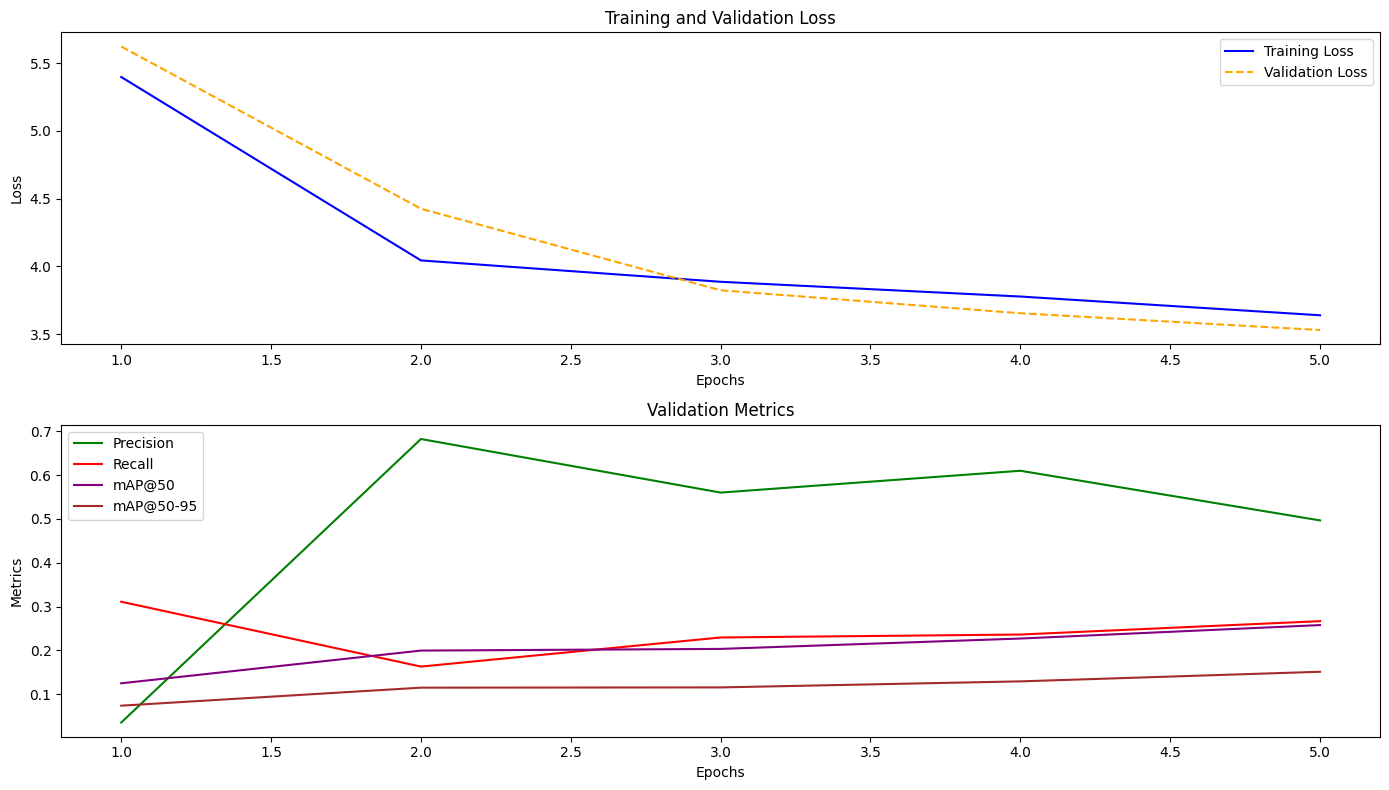

In [5]:
mt.plot_yolo_metrics("runs/train/finetuned_model/results.csv")

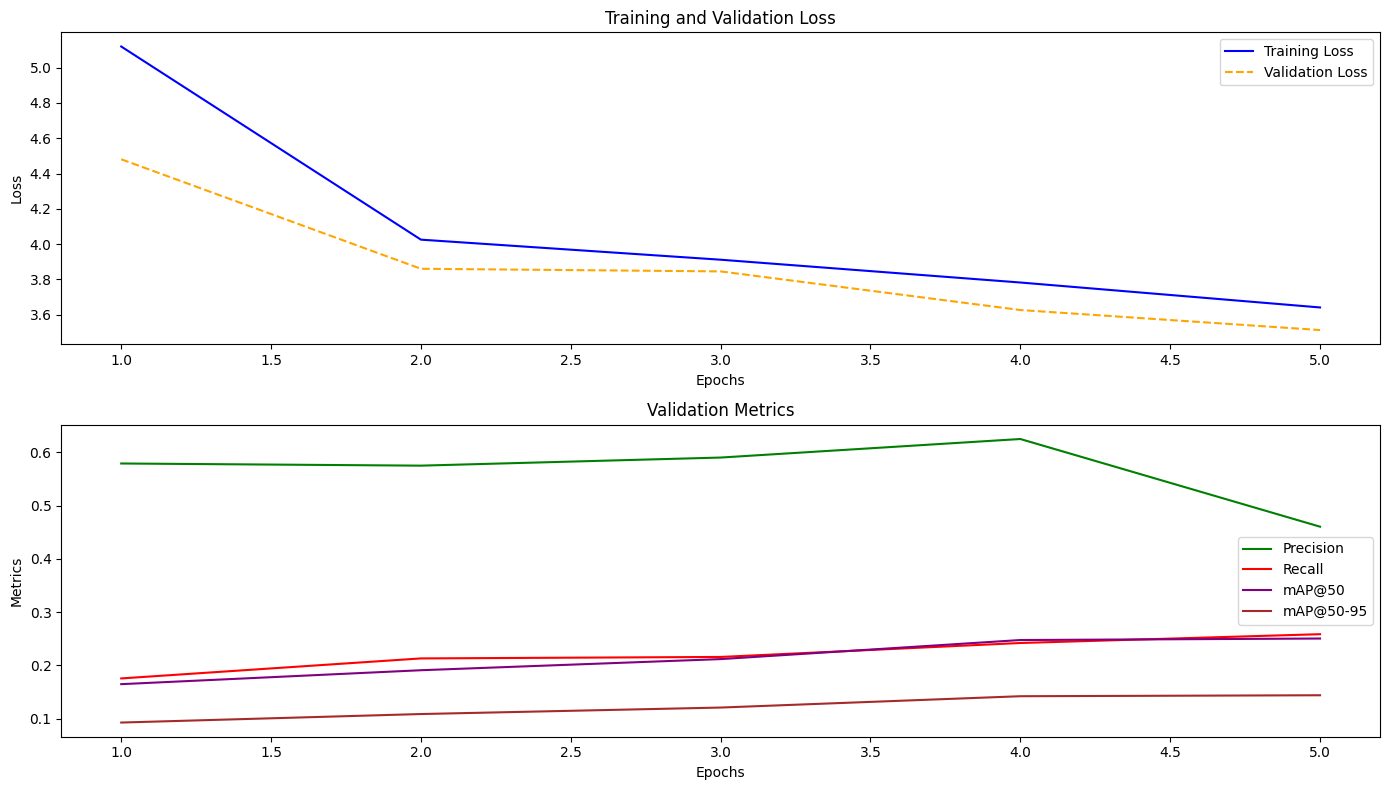

In [6]:
mt.plot_yolo_metrics("runs/train/finetuned_model2/results.csv")

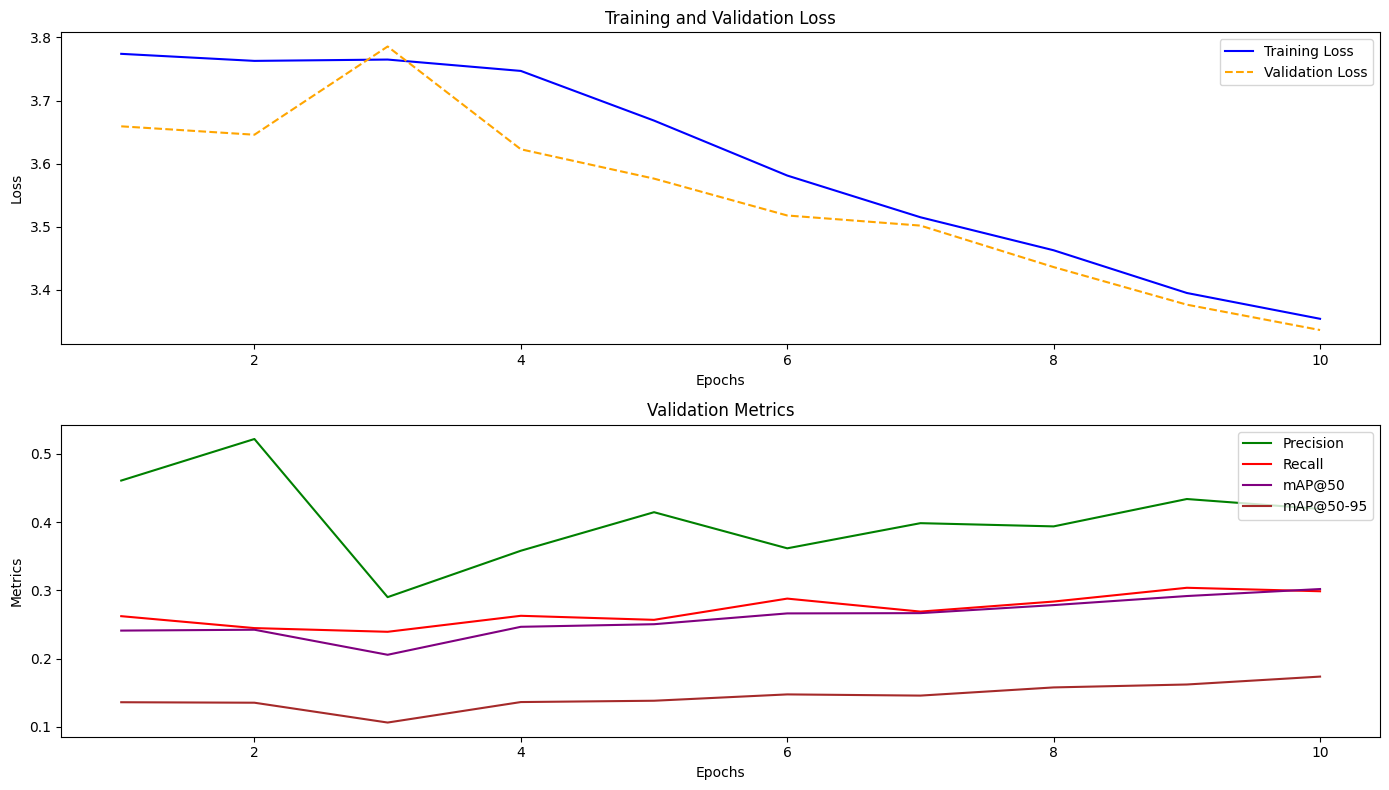

In [7]:
mt.plot_yolo_metrics("runs/train/finetuned_model3/results.csv")

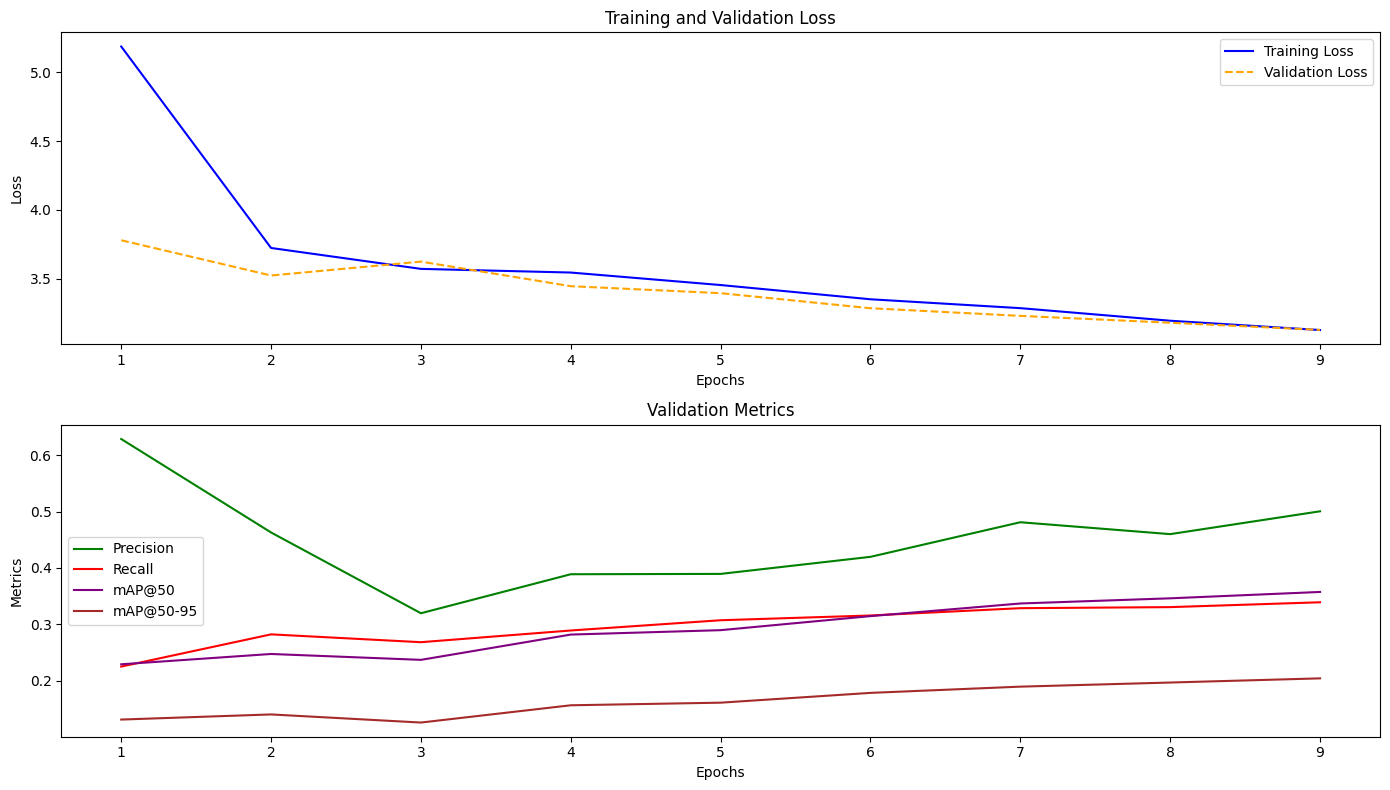

In [8]:
mt.plot_yolo_metrics("runs/train/finetuned_model4/results.csv")

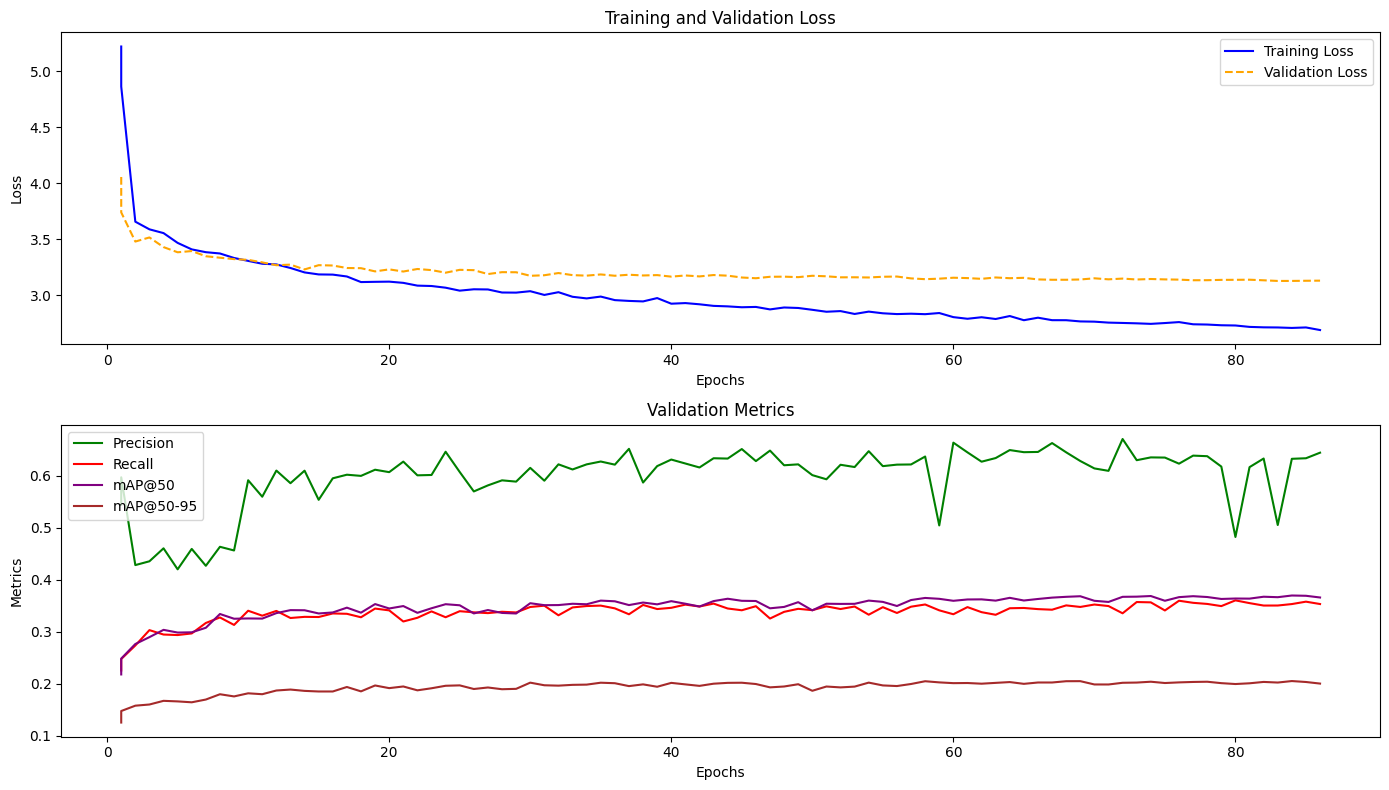

In [ ]:
mt.plot_yolo_metrics("runs/train/finetuned_model5/results.csv")

In [ ]:
g_model = YOLO("runs/train/finetuned_model5/weights/best.pt")

#g_model.val()
# Run inference on a test image

results = g_model("dataset/images/val/b1c66a42-6f7d68ca.jpg")



image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 17 cars, 2 traffic lights, 4 traffic signs, 177.2ms
Speed: 3.1ms preprocess, 177.2ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)
